In [1]:
#%% Libraries import
import sys  
sys.path.insert(1, '/Users/skardova/Dropbox/Lungs/HiDeNN_1D/hidenn_1d')

from HiDeNN_PDE import MeshNN, NeuROM, MeshNN_2D, MeshNN_1D
# Import pre-processing functions
import Bin.Pre_processing as pre
# Import torch librairies
import torch
import torch.nn as nn

# Import Training funcitons
from Bin.Training import Training_1D_FEM_LBFGS
#Import post processing libraries
import Post.Plots as Pplot
import time
import os
import torch._dynamo as dynamo
mps_device = torch.device("mps")
from importlib import reload  # Python 3.4+
import tomllib
import numpy as numpy
import argparse



In [2]:
# Load default configuration file (defines dimension, domain, boundary conditions, number of training iterations etc.)
Default_config_file = '/Users/skardova/Dropbox/Lungs/HiDeNN_1D/hidenn_1d/Configuration/config_1D.toml'

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('-cf',type=str, help = 'path to the desired configuration file', default=Default_config_file, action = 'store')
    
    args, unknown = parser.parse_known_args()

    inputs = vars(args)
    print(f"* Executing job in {args.cf}")

with open(args.cf, mode="rb") as f:
    config = tomllib.load(f)

* Executing job in /Users/skardova/Dropbox/Lungs/HiDeNN_1D/hidenn_1d/Configuration/config_1D.toml


In [34]:
# Experiment setting: trapezoidal rule
# Tested variants: 6 mesh resolutions, 3 training sets, fixed and r-adaptive mesh

mesh_resolution = [10,21,41,80,160,324]
training_points = [10,20,30]

setting = ["fixed", "r-adaptive"]
config["solver"]["IntegralMethod"] == "Trapezoidal"

loss_u = numpy.zeros((len(setting),len(mesh_resolution), len(training_points)))
loss_grad = numpy.zeros((len(setting),len(mesh_resolution), len(training_points)))

for t in range(len(training_points)):
    config["training"]["Points_per_element"] = training_points[t]
    for set in range(len(setting)):
        if setting[set] == "fixed":
            config["solver"]["FrozenMesh"] = True
        elif setting[set] == "r-adaptive":
            config["solver"]["FrozenMesh"] = False

        for res in range(len(mesh_resolution)):

            config["interpolation"]["np"] = mesh_resolution[res]
            

            # Load parameters
            Mat = pre.Material(     flag_lame = True,                          # If True should input lmbda and mu instead of E and nu
                                    coef1     = config["material"]["E"],        # Young Modulus
                                    coef2     = config["material"]["A"]        # Poisson's ratio
                                )

            MaxElemSize = pre.ElementSize(
                                            dimension     = config["interpolation"]["dimension"],
                                            L             = config["geometry"]["L"],
                                            order         = config["interpolation"]["order"],
                                            np            = config["interpolation"]["np"],
                                        )

            Excluded = []

            Mesh_object = pre.Mesh( 
                                            config["geometry"]["Name"],                 # Create the mesh object
                                            MaxElemSize, 
                                            config["interpolation"]["order"], 
                                            config["interpolation"]["dimension"]
                                    )

            Mesh_object.AddBorders(config["Borders"]["Borders"])
            Mesh_object.AddBCs(                                                         # Include Boundary physical domains infos (BCs+volume)
                                            config["geometry"]["Volume_element"],
                                            Excluded,
                                            config["DirichletDictionryList"]
                                )                   

            Mesh_object.MeshGeo()                                                       # Mesh the .geo file if .msh does not exist
            Mesh_object.ReadMesh() 

            # Vtk file not necessary if not using reference element implementation
            if config["solver"]["IntegralMethod"] == "Gaussian_quad":
                Mesh_object.ExportMeshVtk1D()

            # Build the assembly weight matrix if needed
            if config["interpolation"]["dimension"] ==1 and config["solver"]["IntegralMethod"] == "Trapezoidal":
                Mesh_object.AssemblyMatrix()                                            

            if int(Mesh_object.dim) != int(Mesh_object.dimension):
                raise ValueError("The dimension of the provided geometry does not match the job dimension")

            if config["solver"]["TrainingStrategy"]=="Integral":
                match config["solver"]["IntegralMethod"]:                          
                    case "Gaussian_quad":
                        Model_FEM = MeshNN_1D(Mesh_object, config["interpolation"]["n_integr_points"])  
                    case "Trapezoidal":
                        Model_FEM = MeshNN(Mesh_object)

            if config["solver"]["TrainingStrategy"]=="Mixed":
                if config["solver"]["IntegralMethod"] == "Gaussian_quad":
                    Model_FEM = MeshNN_1D(Mesh_object, config["interpolation"]["n_integr_points"])
                    Model_test = MeshNN_1D(Mesh_object, config["interpolation"]["n_integr_points"])  
                    Model_test.Freeze_Mesh()

            # Default setting
            Model_FEM.Freeze_Mesh()
            Model_FEM.UnFreeze_FEM()

            if not config["solver"]["FrozenMesh"]:
                Model_FEM.UnFreeze_Mesh()    

            if config["solver"]["TrainingStrategy"]=="Mixed":
                Model_FEM = Training_1D_FEM_LBFGS(Model_FEM, config, Mat, Model_test)
            else:
                Model_FEM = Training_1D_FEM_LBFGS(Model_FEM, config, Mat)

            l2_loss, l2_loss_grad = Pplot.Normalized_error_1D(Model_FEM,config,Mat)

            
            loss_u[set,res, t] = l2_loss
            loss_grad[set,res, t] = l2_loss_grad


 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       9
 * No excluded points:          True
epoch =  1
     loss =  -0.013471980208606512
     loss_decrease =  1.0134719802086065
epoch =  2
     loss =  -0.013471980208606512
     loss_decrease =  0.0
epoch =  3
     loss =  -0.013471980208606512
     loss_decrease =  0.0
epoch =  4
     loss =  -0.013471980208606512
     loss_decrease =  0.0
epoch =  5
     loss =  -0.013471980208606512
     loss_decrease =  0.0
epoch =  6
     loss =  -0.013471980208606512
     loss_decrease =  0.0
* Final training loss: -1.3472e-02
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \

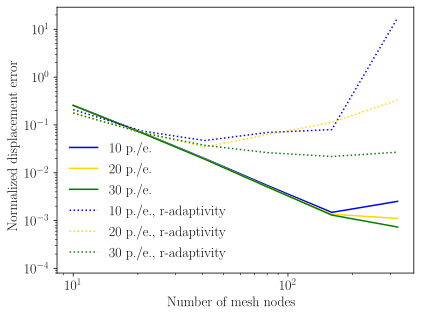

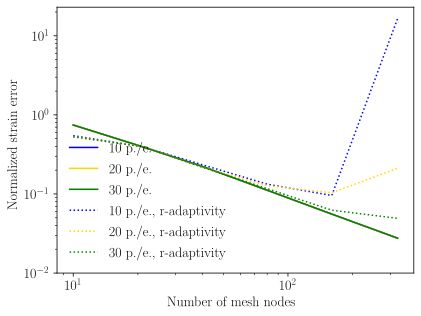

In [39]:
import matplotlib.pyplot as plt
import matplotlib

# Plot normalized displacement error

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

plt.plot(mesh_resolution, loss_u[0,:,0],'-', color = "blue", label = '10 p./e.')
plt.plot(mesh_resolution, loss_u[0,:,1],'-', color = "gold", label = '20 p./e.')
plt.plot(mesh_resolution, loss_u[0,:,2],'-', color = "green", label = '30 p./e.')

plt.plot(mesh_resolution, loss_u[1,:,0],':', color = "blue", label = '10 p./e.,  r-adaptivity')
plt.plot(mesh_resolution, loss_u[1,:,1],':', color = "gold", label = '20 p./e.,  r-adaptivity')
plt.plot(mesh_resolution, loss_u[1,:,2],':', color = "green", label = '30 p./e.,  r-adaptivity')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.00008, 29])

plt.xlabel("Number of mesh nodes")
plt.ylabel("Normalized displacement error")
plt.legend(loc="lower left", frameon=False )
plt.show()

# Plot normalized strain error

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

plt.plot(mesh_resolution, loss_grad[0,:,0],'-', color = "blue", label = '10 p./e.')
plt.plot(mesh_resolution, loss_grad[0,:,1],'-', color = "gold", label = '20 p./e.')
plt.plot(mesh_resolution, loss_grad[0,:,2],'-', color = "green", label = '30 p./e.')

plt.plot(mesh_resolution, loss_grad[1,:,0],':', color = "blue", label = '10 p./e.,  r-adaptivity')
plt.plot(mesh_resolution, loss_grad[1,:,1],':', color = "gold", label = '20 p./e.,  r-adaptivity')
plt.plot(mesh_resolution, loss_grad[1,:,2],':', color = "green", label = '30 p./e.,  r-adaptivity')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.01, 23])

plt.xlabel("Number of mesh nodes")
plt.ylabel("Normalized strain error")
plt.legend(loc="lower left", frameon=False )
plt.show()